# Speckle project documentation (24-hours)

## Enter information:

In [1]:
video_time_length=60 #s
video_frame_numbers=1129 #frames
imgname='1120f_FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted'
foldername='/Volumes/wwyyrx/Wenyun/Speckle/FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted/'

## Imports

In [2]:
%cd /Users/wenyun/Desktop/python/DSHpy-master 

# 2. install the project/module
!python setup.py install

# 3. Add the project directory to the path
import os, sys

sys.path.append(os.getcwd())

/Users/wenyun/Desktop/python/DSHpy-master
running install
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing DSH.egg-info/PKG-INFO
writing dependency_links to DSH.egg-info/dependency_links.txt
writing requirements to DSH.egg-info/requires.txt
writing top-level names to DSH.egg-info/top_level.txt
reading manifest file 'DSH.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'DSH.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
creating build/bdist.macosx-10.9-

In [3]:
import speckle
from speckle.inference.read_in_data import read_in_data
from speckle.inference.correlation_heatmap import get_correlation,dump_heatmap,display_correlation_heatmaps,mask_heatmap,plot_radius_distribution
from speckle.inference.calculating_tau import objective, avg_correlation_single_px, plot_correlation_vs_lagtime,fit_exponential_decay, reconstruct,avg_correlation,calculate_correlation_pixel
from speckle.inference.dedrift import dedrift_videos

In [4]:
from PIL import Image
import numpy as np
from ellipse import LsqEllipse
from matplotlib.patches import Ellipse
from skimage import io
import math
import pickle
import statistics
from statistics import mean
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks


from pandas import read_csv
from scipy.optimize import curve_fit

%matplotlib inline
import matplotlib.pyplot as plt
import os

import seaborn as sns
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import CorrMaps as CM

## Read in video

In [5]:
framespeed=video_time_length/video_frame_numbers

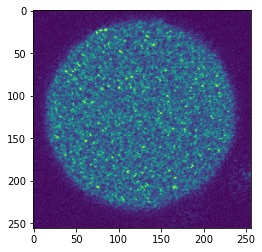

In [6]:
img=read_in_data(foldername,imgname)

## Dedrifting if necessary

In [ ]:
particle_centers=foldername+"centers_7h.csv"

In [ ]:
dedrift_videos(img,particle_centers,foldername,imgname)

In [ ]:
imgname=imgname+"_dedrifted"
img=read_in_data(foldername,imgname)

## setting up kernel and generate correlation maps

In [7]:
#info
kernel_size=5
laglist=list(range(1,900,1))
#test_ROI = [x,y,w,h]
testROI=[140,90,40,40]
tRange=None

In [8]:
## don't change please
def set_up_kernel(kernel_size):
    KernelSpecs = DSH.Kernel.Kernel()
    KernelSpecs.Initialize(shape=kernel_size, kernel_type='Gauss', params={'sigma':[kernel_size, kernel_size]}, padding=True)
    return KernelSpecs

def compute_correlation_maps(foldername, imgname, kernel, laglist, testROI=None, tRange=None):
    froot = os.path.join(foldername)
    fname = os.path.join(froot, imgname+'.raw')
    metadata_fname = os.path.join(froot, imgname+'.ini')
    
    mi_file = MI.MIfile(fname, metadata_fname)
    mi_file.OpenForReading()
    mi_file.Read(zRange=None, cropROI=None, closeAfter=False)
    mi_file.Close()
    
    position=str(testROI)+'_'+str(tRange)
    froot = os.path.join(foldername+imgname+'_'+position)
    #KernelSpecs.SetPadding(False)
    corrmap = CM.CorrMaps(mi_file, froot, laglist, kernel, imgRange=tRange, cropROI=testROI)
    
    cmap_list = corrmap.Compute(silent=False, return_maps=False)
    
def load_correlation_maps(foldername,imgname,testROI, tRange):
    froot = os.path.join(foldername+imgname+'_'+str(testROI)+'_'+str(tRange))
    corr_maps = CM.LoadFromConfig(os.path.join(froot, 'CorrMapsConfig.ini'), outFolder=froot)
    return corr_maps

In [9]:
kernel=set_up_kernel(kernel_size)

In [ ]:
compute_correlation_maps(foldername, imgname, kernel, laglist, testROI, tRange)

In [13]:
corr_maps=load_correlation_maps(foldername,imgname,testROI, tRange)

OSError: Configuration file /Volumes/wwyyrx/Wenyun/Speckle/FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted/1120f_FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted_[140, 90, 40, 40]_(1,900,1)/CorrMapsConfig.ini not found

In [16]:
froot = os.path.join(foldername+'1120f_FUS_24h_condensate_speckle_BF_1min_#2_equator_dedrifted_[140,90,40,40]_(1,900,1)')
corr_maps = CM.LoadFromConfig(os.path.join(froot, 'CorrMapsConfig.ini'), outFolder=froot)

## Calculate correlation heatmap

In [ ]:
numberT_average=50
loadtRange = [0,200,round(200/numberT_average)]
t_range=range(0,200,round(200/numberT_average))
if testROI is None:
    heatmap_size=img.shape[1:3]
else:
    heatmap_size=[testROI[2],testROI[3]]

In [ ]:
dump_list=[1]

In [ ]:
for i in dump_list:
    dump_heatmap(i,laglist,loadtRange,t_range, corr_maps,heatmap_size,numberT_average, foldername)

In [ ]:
heatmap_lag=pickle.load(open(foldername+'_heatmap_decay_1_lagtime_'+str(numberT_average)+'avg.p', "rb"))

In [ ]:
display_correlation_heatmaps(1, numberT_average,0, 0.7, foldername)

In [ ]:
## need to calculate radius mannually
line_intensity=[]
y=247
for x in range(0,500):
    line_intensity.append(heatmap_lag[y,x])
    if heatmap_lag[y,x]>0.3:
        print(heatmap_lag[y,x])
        print([y,x])
plt.plot(line_intensity,'.')

In [ ]:
center=[247,256] #[y,x]
radius=200
radius_outer=radius-7
scale_bar_position=[400,450] #[x,y]
scale_ratio=20.5155

In [ ]:
heatmap_masked=mask_heatmap(center,radius_outer,heatmap_lag, scale_bar_position, scale_ratio)

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap_masked,vmin=0, vmax=0.7)
plt.show()

In [ ]:
## dump raw data
pickle.dump(heatmap_masked, open(foldername+'_heatmap_masked_decay_1_lagtime_'+str(numberT_average)+'avg.p',"wb"))

In [ ]:
heatmap_masked_try=pickle.load( open('/Volumes/wwyyrx/Wenyun/Speckle/Data_for_Yi/24houraged', "rb" ) )
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap_lag101,vmin=0, vmax=0.7)
plt.show()

## Compute single pixel decay constant tau

In [ ]:
numberT_average_tau=100
loadtRange_tau = [0,200,round(200/numberT_average_tau)]
t_range_tau=range(0,200,round(200/numberT_average_tau))
laglist_tau=list(range(5,900,5))
lagtime_tau= [element * framespeed for element in laglist_tau]

In [ ]:
def single_pixel_decay_constant(y,x,startidx=1,endidx=10):
    correlation_value=avg_correlation_single_px(corr_maps,[y,x],loadtRange_tau,t_range_tau,laglist_tau, laglist)
    plt.figure()
    plot_correlation_vs_lagtime(correlation_value,lagtime_tau)
    length=len(correlation_value)
    plateau=np.mean(correlation_value[length-int(length/9):length])
    print("plateau is:",plateau)
    plt.figure()
    decay_time, a,b =fit_exponential_decay(plateau,correlation_value,lagtime_tau,startidx,endidx, plotBoolean=True)
    reconstruct(lagtime_tau,plateau,correlation_value,a,b)

In [ ]:
y=5
x=5
single_pixel_decay_constant(y,x,startidx=1,endidx=10)

## Computing average correlation decay

In [17]:
# create pixel list
px_list_whole=[]
for y in range(testROI[3]):
    for x in range(testROI[2]):
        px_list_whole.append([y,x])

In [18]:
numberT_average_tau=50
loadtRange_tau = [0,200,round(200/numberT_average_tau)]
t_range_tau=range(0,200,round(200/numberT_average_tau))
laglist_tau=list(range(1,900,1))
lagtime_tau= [element * framespeed for element in laglist_tau]

In [19]:
def list_pixel_decay_constant(px_list,startidx=1,endidx=10):
    correlation_value=avg_correlation(corr_maps,px_list,loadtRange_tau,t_range_tau,laglist_tau, laglist)
    plt.figure()
    plot_correlation_vs_lagtime(correlation_value,lagtime_tau)
    length=len(correlation_value)
    plateau=np.mean(correlation_value[length-int(length/9):length])
    print("plateau is:",plateau)
    plt.figure()
    decay_time, a,b =fit_exponential_decay(plateau,correlation_value,lagtime_tau,startidx,endidx, plotBoolean=True)
    reconstruct(lagtime_tau,plateau,correlation_value,a,b)
    return correlation_value

[0, 0]
[0, 1]
[0, 2]
[0, 3]
[0, 4]
[0, 5]
[0, 6]
[0, 7]
[0, 8]
[0, 9]
[0, 10]
[0, 11]
[0, 12]
[0, 13]
[0, 14]
[0, 15]
[0, 16]
[0, 17]
[0, 18]
[0, 19]
[0, 20]
[0, 21]
[0, 22]
[0, 23]
[0, 24]
[0, 25]
[0, 26]
[0, 27]
[0, 28]
[0, 29]
[0, 30]
[0, 31]
[0, 32]
[0, 33]
[0, 34]
[0, 35]
[0, 36]
[0, 37]
[0, 38]
[0, 39]
[1, 0]
[1, 1]
[1, 2]
[1, 3]
[1, 4]
[1, 5]
[1, 6]
[1, 7]
[1, 8]
[1, 9]
[1, 10]
[1, 11]
[1, 12]
[1, 13]
[1, 14]
[1, 15]
[1, 16]
[1, 17]
[1, 18]
[1, 19]
[1, 20]
[1, 21]
[1, 22]
[1, 23]
[1, 24]
[1, 25]
[1, 26]
[1, 27]
[1, 28]
[1, 29]
[1, 30]
[1, 31]
[1, 32]
[1, 33]
[1, 34]
[1, 35]
[1, 36]
[1, 37]
[1, 38]
[1, 39]
[2, 0]
[2, 1]
[2, 2]
[2, 3]
[2, 4]
[2, 5]
[2, 6]
[2, 7]
[2, 8]
[2, 9]
[2, 10]
[2, 11]
[2, 12]
[2, 13]
[2, 14]
[2, 15]
[2, 16]
[2, 17]
[2, 18]
[2, 19]
[2, 20]
[2, 21]
[2, 22]
[2, 23]
[2, 24]
[2, 25]
[2, 26]
[2, 27]
[2, 28]
[2, 29]
[2, 30]
[2, 31]
[2, 32]
[2, 33]
[2, 34]
[2, 35]
[2, 36]
[2, 37]
[2, 38]
[2, 39]
[3, 0]
[3, 1]
[3, 2]
[3, 3]
[3, 4]
[3, 5]
[3, 6]
[3, 7]
[3, 8]
[3, 9]


<Figure size 432x288 with 0 Axes>

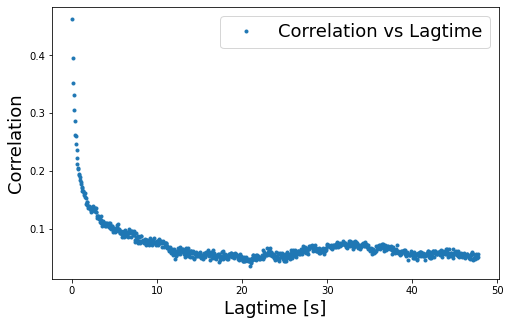

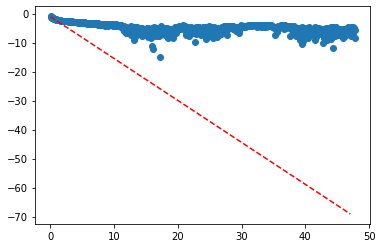

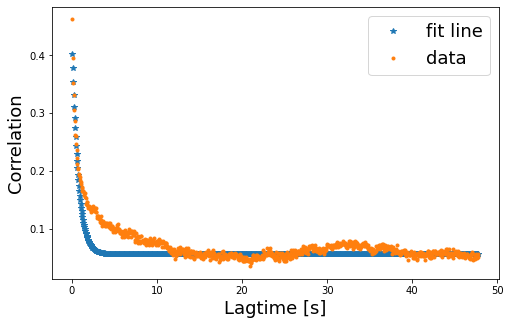

In [20]:
values=list_pixel_decay_constant(px_list_whole)

Text(0, 0.5, 'Correlation')

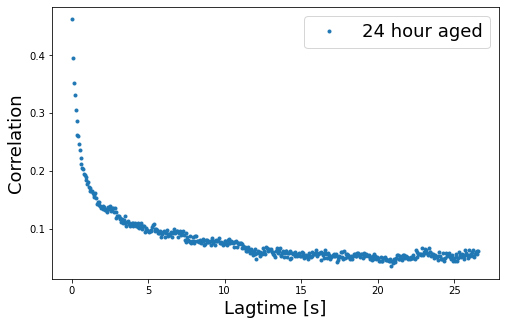

In [33]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_tau[0:500],values[0:500],'.',label='24 hour aged')
plt.legend(fontsize=18)
plt.xlabel("Lagtime [s]",fontsize=18)
plt.ylabel("Correlation",fontsize=18)

In [21]:
pickle.dump(values, open(foldername+'correlation_values.p',"wb"))

In [22]:
pickle.dump(lagtime_tau, open(foldername+'lagtime.p',"wb"))

In [26]:
values_7=pickle.load(open('/Volumes/wwyyrx/Wenyun/Speckle/Data_for_Yi/7houraged/correlation_values.p',"rb"))

In [27]:
lag_7=pickle.load(open('/Volumes/wwyyrx/Wenyun/Speckle/Data_for_Yi/7houraged/lagtime.p',"rb"))

Text(0, 0.5, 'Correlation')

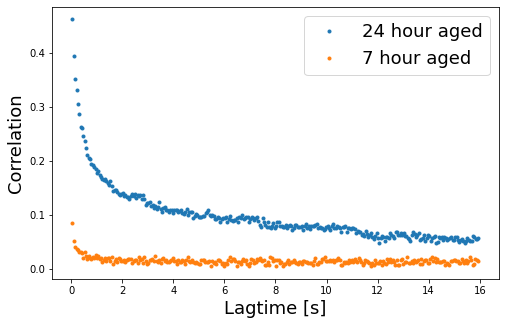

In [31]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_tau[0:300],values[0:300],'.',label='24 hour aged')
plt.plot(lag_7[0:300],values_7[0:300],'.',label='7 hour aged')
plt.legend(fontsize=18)
plt.xlabel("Lagtime [s]",fontsize=18)
plt.ylabel("Correlation",fontsize=18)